In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
PROJECT_LOCATION = "/content/drive/MyDrive/playground/medical_image_analysis/Homework1"
os.chdir(PROJECT_LOCATION)

In [ ]:
DATA_LOCATION = "./data/"

In [ ]:
import numpy as np
from numpy.random import default_rng
import cv2 as cv
from google.colab.patches import cv2_imshow
from skimage import io
from skimage import color
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage

In [ ]:
cell_file = DATA_LOCATION + "im1.jpg"
cell_mask_file = DATA_LOCATION + "im1_gold_mask.txt"
cell_color_file = DATA_LOCATION + "im1_gold_cells.txt"

In [ ]:
WHITE_LIMIT = 150
def ObtainForegroundMask(image):
  image = cv.GaussianBlur(image, (11,11), 0)
  r_image = image[:,:,0]

  g_image = r_image
  kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
  log_image = cv.filter2D(g_image, cv.CV_32F, kernel)
  
  log_image = np.absolute(log_image)
  sharp = np.float32(g_image)
  res_image = sharp + 2 * log_image

  # cv2_imshow(res_image)
  res_image = np.clip(res_image, 0, 255)
  res_image = res_image.astype('uint8')
  log_image = np.clip(log_image, 0, 255)
  log_image = log_image.astype('uint8')
  
  # process on gray blur
  th, im_th = cv.threshold(res_image, WHITE_LIMIT, 255, cv.THRESH_BINARY)
  

  kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
  im_th = cv.morphologyEx(im_th, cv.MORPH_OPEN, kernel, iterations = 3)
  im_th = cv.morphologyEx(im_th, cv.MORPH_CLOSE, kernel, iterations = 15)

  # 255 to 1 for discrimination
  im_th[im_th == 255] = 1
  
  return im_th

In [ ]:
cell_image = cv.imread(cell_file)
foreground_mask = ObtainForegroundMask(cell_image)


In [ ]:
def ShowForegroundMask(mask_file, cell_image, mask_found):
  mask = np.loadtxt(mask_file, dtype='uint8')
  mask[mask == 1] = 255
  mask_found[mask_found == 1] = 255
  mask = color.gray2rgb(mask)
  mask_found = color.gray2rgb(mask_found)
  final_frame = cv.hconcat((cell_image, mask, mask_found))
  cv2_imshow(final_frame)


def ShowCellLocations(location_image_file, cell_image, dist_image):
  location = np.loadtxt(location_image_file, dtype='uint16')
  location[location != 0] = 255
  location = location.astype('uint8')
  dist_image = dist_image.astype('uint8')
  location = color.gray2rgb(location)
  dist_image = color.gray2rgb(dist_image)

  final_frame = cv.hconcat((cell_image, location, dist_image))
  cv2_imshow(final_frame)

In [ ]:
def calc_foreground_tp(ground_truth, found):
  return np.sum(np.logical_and(ground_truth == 1, found == 1))

def calc_foreground_fp(ground_truth, found):
  return np.sum(np.logical_and(ground_truth == 0, found == 1))

def calc_foreground_fn(ground_truth, found):
  return np.sum(np.logical_and(ground_truth == 1, found == 0))

def calc_foreground_recall(ground_truth, found):
  tp = calc_foreground_tp(ground_truth, found)
  fn = calc_foreground_fn(ground_truth, found)
  return tp / (tp + fn)


def calc_foreground_precision(ground_truth, found):
  tp = calc_foreground_tp(ground_truth, found)
  fp = calc_foreground_fp(ground_truth, found)
  return tp / (tp + fp)


def calc_cell_tp(ground_truth, found):
  nm = np.max(ground_truth)
  res = 0
  for i in range(1, nm + 1):
    one_count = np.sum(np.logical_and(ground_truth == i, found == 1))
    if one_count == 1:
      res += 1
  return res

def calc_cell_fp(ground_truth, found):
  return np.sum(np.logical_and(ground_truth == 0, found == 1))

def calc_cell_fn(ground_truth, found):
  return np.max(ground_truth) - calc_cell_tp(ground_truth, found)


def calc_cell_recall(ground_truth, found):
  tp = calc_cell_tp(ground_truth, found)
  fn = calc_cell_fn(ground_truth, found)
  return tp / (tp + fn)

def calc_cell_precision(ground_truth, found):
  tp = calc_cell_tp(ground_truth, found)
  fp = calc_cell_fp(ground_truth, found)
  return tp / (tp + fp)


def f_score(ground_truth, found, prec_func, recall_func):
  precision = prec_func(ground_truth, found)
  recall = recall_func(ground_truth, found)
  return 2 * precision * recall / (precision + recall)

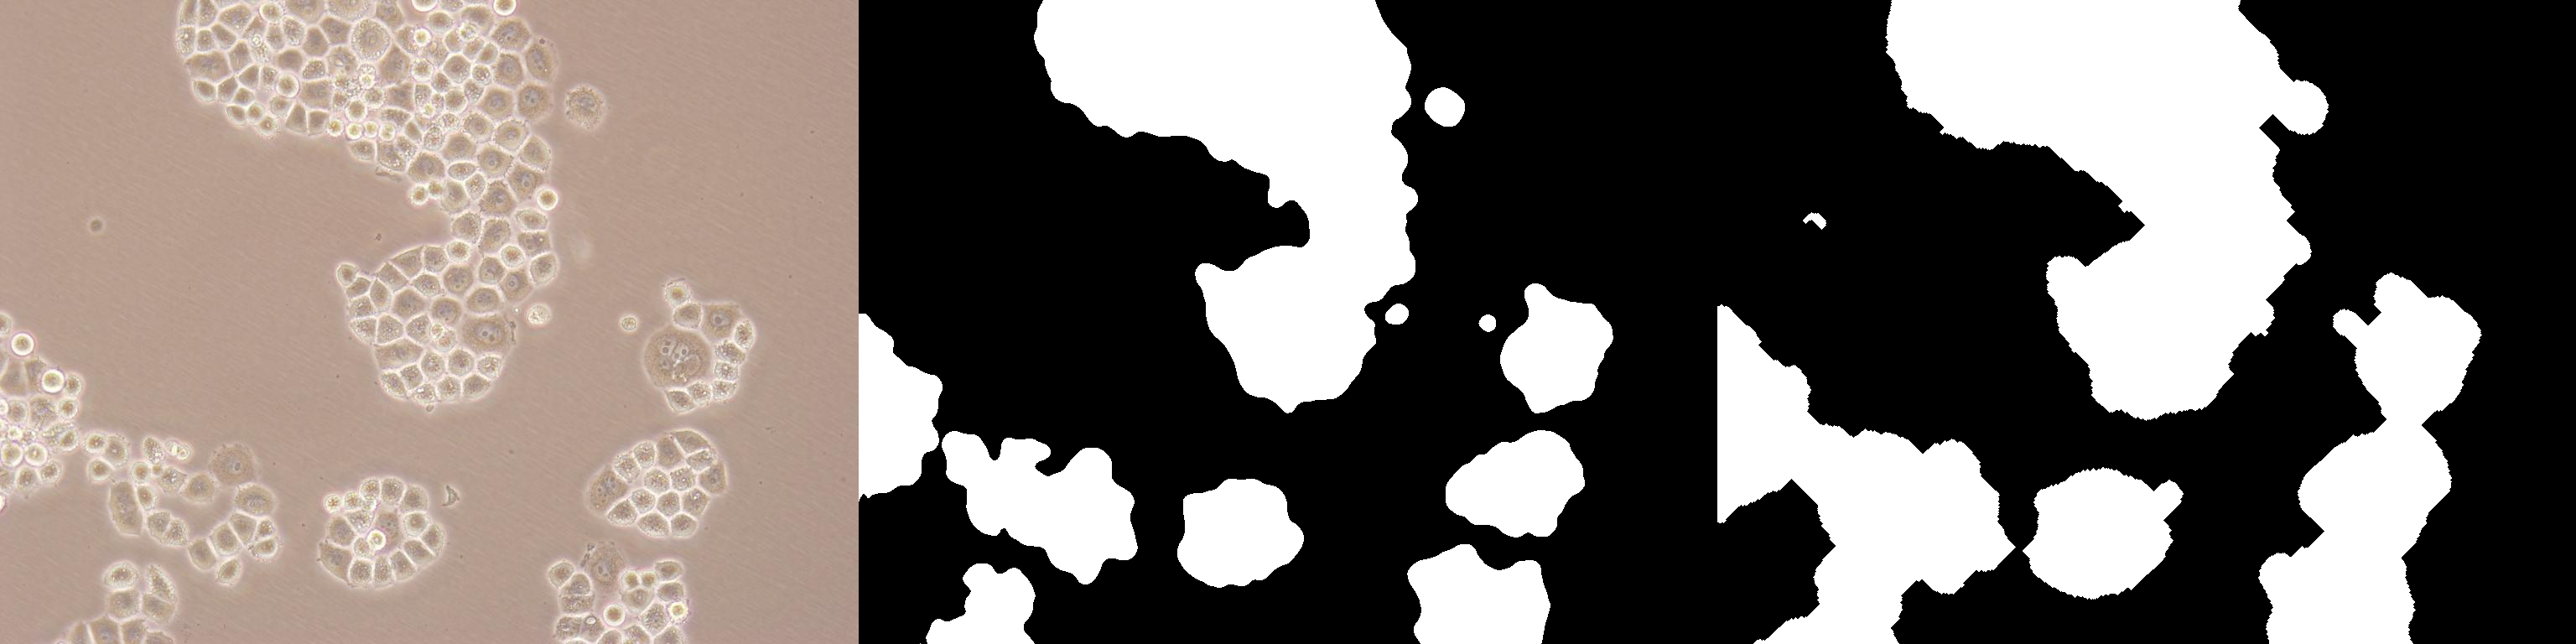

1.0
0.7889750713243721
0.8820414369891656


In [ ]:
# write the part I here.
ShowForegroundMask(cell_mask_file, cell_image, foreground_mask.copy())
ground_truth_mask = np.loadtxt(cell_mask_file, 'uint8')


print(calc_foreground_recall(ground_truth_mask, foreground_mask))
print(calc_foreground_precision(ground_truth_mask, foreground_mask))
print(f_score(ground_truth_mask, foreground_mask, calc_foreground_recall, calc_foreground_precision))

In [ ]:
import imutils

def find_center(c):
  M = cv.moments(c)
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])
  return (cY, cX)

# TODO: find cells using mask
WHITE_LIMIT = 150
def FindCellLocations(image, mask):
  mask[mask == 1] = 255
  image = cv.GaussianBlur(image, (5,5), 0)
  masked_image = cv.bitwise_and(image, image, mask = mask)
  
  r_image = masked_image[:,:,0]

  g_image = r_image
  kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
  log_image = cv.filter2D(g_image, cv.CV_32F, kernel)
  


  log_image = np.absolute(log_image)
  sharp = np.float32(g_image)
  res_image = sharp - log_image

  res_image = np.clip(res_image, 0, 255)
  res_image = res_image.astype('uint8')
  log_image = np.clip(log_image, 0, 255)
  log_image = log_image.astype('uint8')


  th, im_th = cv.threshold(res_image, WHITE_LIMIT, 255, cv.THRESH_BINARY)

  kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
  im_th = cv.morphologyEx(im_th, cv.MORPH_OPEN, kernel, iterations = 2)


  cells = cv.bitwise_not(im_th, mask = mask)

  dist = cv.distanceTransform(cells, cv.DIST_L2, 3)
  cv.normalize(dist, dist, 0, 255, cv.NORM_MINMAX)

  dist = cv.erode(dist, kernel, iterations = 3)
  dist = cv.morphologyEx(dist, cv.MORPH_OPEN, kernel, iterations = 3)


  th, im_th = cv.threshold(dist, 1, 255, cv.THRESH_BINARY)

  im_th = im_th.astype('uint8')
  # find contours
  cnts = cv.findContours(im_th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  xy = [find_center(c) for c in cnts]
  
  return xy, dist

In [ ]:
xy, dist = FindCellLocations(cell_image, foreground_mask)

In [ ]:
def xy_image(xy, shape):
  image = np.zeros(shape, 'uint8')
  for center in xy:
    image[center] = 1
  return image


# write part II here.
ShowCellLocations(cell_color_file, cell_image, dist.copy())
xy_image_version = xy_image(xy, dist.shape)
location_int_version = np.loadtxt(cell_color_file, 'uint16')


print(calc_cell_recall(location_int_version, xy_image_version))
print(calc_cell_precision(location_int_version, xy_image_version))
print(f_score(location_int_version, xy_image_version, calc_cell_recall, calc_cell_precision))


NameError: ignored

In [ ]:
def check(next, mask, image, mark):
  if (next[0] >= image.shape[0]):
    return False
  if (next[1] >= image.shape[1]):
    return False
  if (mask[next] == 0):
    return False
  if (image[next] >= 160):
    return False
  if (mark[next] == 1):
    return False
  return True


def region_grow(image, mask, cell, index, arr, mark):
  from queue import Queue
  mark[cell] = 1
  dirs = [[-1,0],[0,-1],[0,1],[1,0]]
  q = Queue()
  q.put((cell, 0))
  arr[cell] = index

  while not q.empty():
    first, depth = q.get()
    if depth == 40:
      continue
    for dir in dirs:
      next = (dir[0] + first[0], dir[1] + first[1])
      if (check(next, mask, image, mark)):
        mark[next] = 1
        q.put((next, depth+1))
        arr[next] = index

    


WHITE_LIMIT = 140
def FindCellBoundaries(image, mask, cells):
  mask[mask == 1] = 255
  image = cv.blur(image, (5,5))
  masked_image = cv.bitwise_and(image, image, mask = mask)
  
  r_image = masked_image[:,:,0]

  g_image = r_image
  kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
  log_image = cv.filter2D(g_image, cv.CV_32F, kernel)
  
  cv.normalize(log_image, log_image, 0, 255, cv.NORM_MINMAX)
  log_image = 255 - log_image
  log_image[log_image > 140] = 127
  log_image[log_image < 110] = 127
  cv.normalize(log_image, log_image, 0, 255, cv.NORM_MINMAX)

  log_image = cv.GaussianBlur(log_image, (5,5), 0)

  


  sharp = np.float32(g_image)
  res_image = sharp + log_image




  cv.normalize(res_image, res_image, 0, 255, cv.NORM_MINMAX)
  res_image = res_image.astype('uint8')

  arr = np.zeros(res_image.shape, 'uint16')
  mark = np.zeros(res_image.shape, 'uint8')

  for i, cell in enumerate(cells, start=1):
    region_grow(res_image, mask, cell, i, arr, mark)

  colored = np.zeros((res_image.shape[0], res_image.shape[1], 3), 'uint8')
  colors = np.random.randint(0,256,size=(len(cells), 3))
  for i in range(len(cells)):
    colored[arr == i+1] = colors[i,:]
  
  
  return arr, colored
  

In [ ]:
cell_boundary, colored = FindCellBoundaries(cell_image, foreground_mask, xy)

In [ ]:
def ShowCellBoundaries(cell_image, color_file, found):
  color_map = np.loadtxt(color_file, dtype='uint16')
  uniques = np.unique(color_map)
  unique_size = uniques.size
  rng = default_rng()
  vals = rng.integers(low=0, high=256, size=(unique_size, 3))
  vals[0] = np.array([0,0,0])


  color_3d_map = color.gray2rgb(color_map)
  for i in np.nditer(uniques):
    color_3d_map[color_map == i] = vals[i]
  color_3d_map = color_3d_map.astype('uint8')

  final_frame = cv.hconcat((cell_image, color_3d_map, found))
  cv2_imshow(final_frame)

In [ ]:
def calc_color_tp(ground_truth, found, ratio = 0.5):
  tp_cnt = 0
  num_ground_truth = np.max(ground_truth)
  num_found = np.max(found)
  mark = np.zeros(np.max(ground_truth))
  for i in range(1, num_found+1):
    marking = 0
    mx_marking = 0
    for j in range(1, num_ground_truth):
      if mark[j] == 1:
        continue
      cur_res = np.sum(np.logical_and(ground_truth == j, found == i))
      if mx_marking < cur_res:
        mx_marking = cur_res
        marking = j
    last_union = np.sum(np.logical_or(ground_truth == marking, found == i))
    if marking != 0 and mx_marking / last_union >= ratio:
      mark[marking] = 1
      tp_cnt += 1
  return tp_cnt


def calc_color_fp(ground_truth, found, ratio = 0.5):
  return np.max(found) - calc_color_tp(ground_truth, found, ratio)

def calc_color_fn(ground_truth, found, ratio = 0.5):
  return np.max(ground_truth) - calc_color_tp(ground_truth, found, ratio)


def calc_color_recall(ground_truth, found, ratio = 0.5):
  tp = calc_color_tp(ground_truth, found, ratio)
  return tp / np.max(found)

def calc_color_precision(ground_truth, found, ratio = 0.5):
  tp = calc_color_tp(ground_truth, found, ratio)
  return tp / np.max(ground_truth)


def color_f_score(ground_truth, found, ratio = 0.5):
  precision = calc_color_precision(ground_truth, found, ratio)
  recall = calc_color_recall(ground_truth, found, ratio)
  return 2 * precision * recall / (precision + recall)

def ratio(img, i):
  return np.sum(img == i) / np.sum(img != 0)

def maximal_overlap(src, dst, cur):
  maximal, index = 0, 0
  for i in range(1, np.max(src)+1):
    cur_sum = np.sum(np.logical_and(src == i, dst == cur))
    if maximal < cur_sum:
      maximal, index = cur_sum, i
  di = 2 * maximal / (np.sum(src == index) + np.sum(dst == cur))
  return index, di


def dice_index(ground_truth, found):
  res = 0

  whole_found = np.sum(found != 0)
  whole_ground = np.sum(ground_truth != 0)


  for i in range(1, np.max(found) + 1):
    grnd_i, di = maximal_overlap(ground_truth, found, i)
    res += di * (np.sum(found == i) / whole_found)
  
  for i in range(1, np.max(ground_truth) + 1):
    found_i, di = maximal_overlap(found, ground_truth, i)
    res += di * (np.sum(ground_truth == i) / whole_ground)
  
  return res / 2



In [ ]:
cell_color_img = np.loadtxt(cell_color_file, 'uint16')

for ratio in [0.5, 0.75, 0.9]:
  print('Ratio : ', ratio)
  print(calc_color_recall(cell_color_img, cell_boundary, ratio))
  print(calc_color_precision(cell_color_img, cell_boundary, ratio))
  print(color_f_score(cell_color_img, cell_boundary, ratio))

print(dice_index(cell_color_img, cell_boundary))

Ratio :  0.5


KeyboardInterrupt: ignored

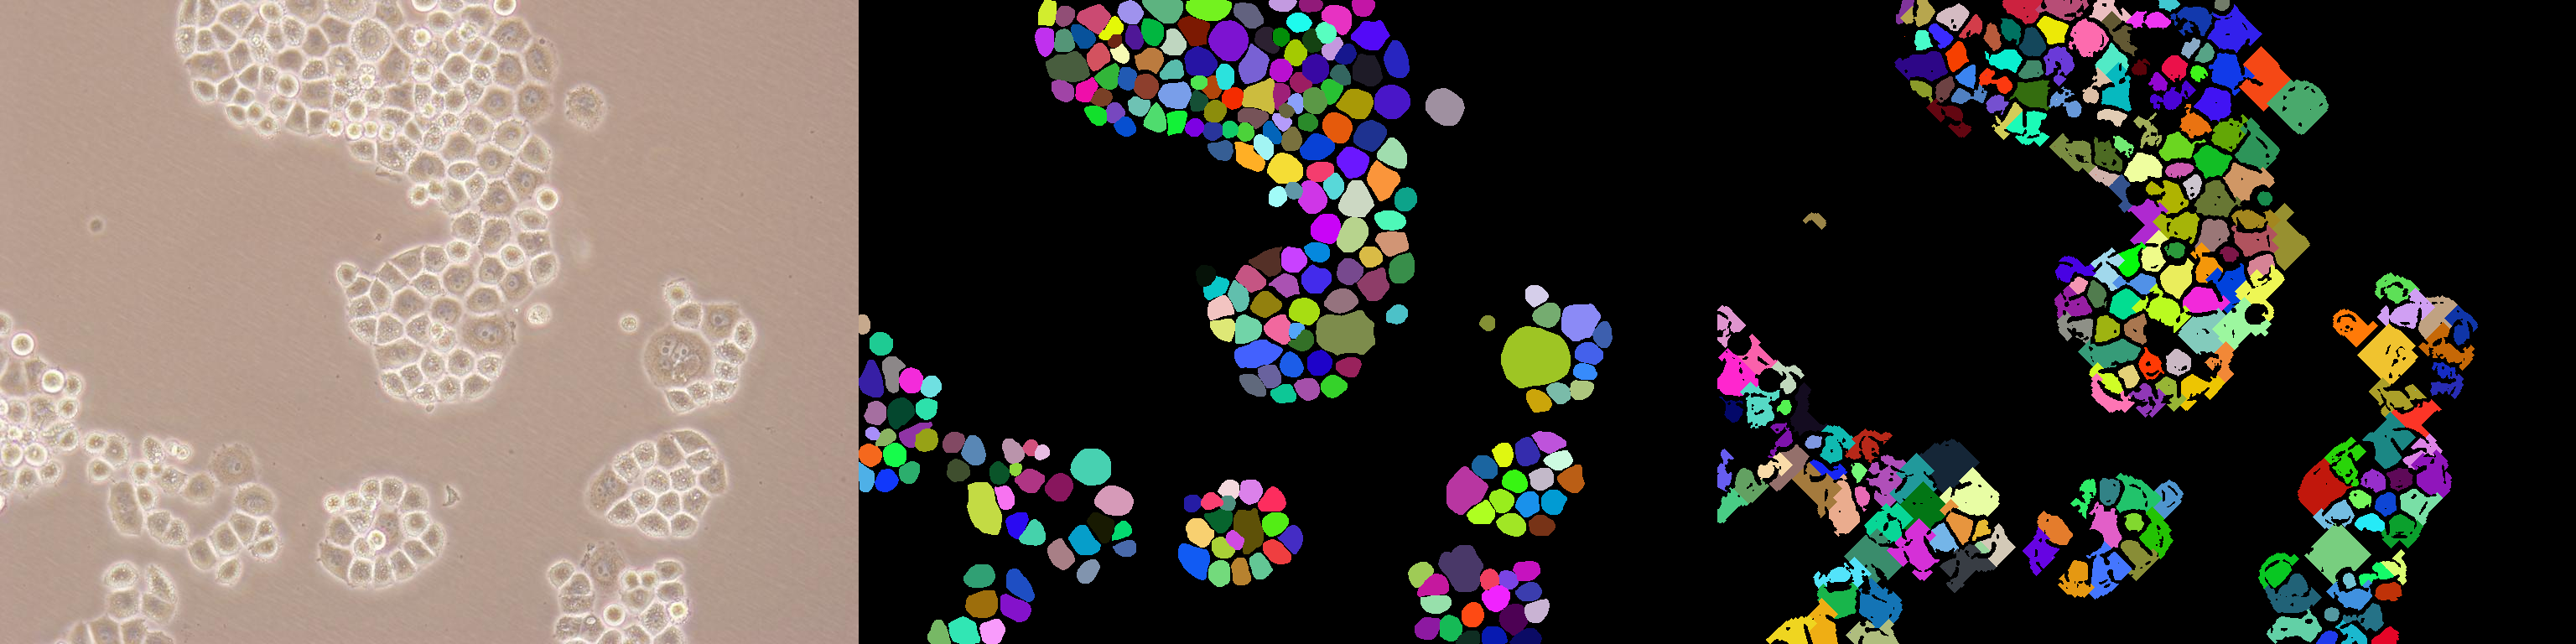

In [ ]:
ShowCellBoundaries(cell_image, cell_color_file, colored)